# **Проектная работа "Отток клиентов"**

#### **Выполнил: студент когорты №15 DS+ Зубков О.В.**
<a id="top"></a>

[Ссылка на репозиторий на ГитХабе](https://github.com/Anatarasss/Learning_with_teacher_proj)


### **Описание проекта**
#### Исходные данные
В распоряжение предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

#### Задача
Построить модель для задачи классификации, которая будет давать прогноз, уйдёт клиент из банка в ближайшее время или нет. Модель должна иметь предельно большое значение F1-меры, но не менее, чем 0.59. Произвести проверку значения F1-меру на тестовой выборке.

Дополнительно производить измерение AUC-ROC и сравнивать её значения с F1-мерой.

#### Ход исследования
1. [Загрузка и подготовка данных](#data)

2. [Исследование баланса классов, обучение модели без учёта дисбаланса.](#disbalance)

3. [Улучшение качества модели.](#model)

4. [Проведение финального тестирования.](#test)

5. [Общие выводы.](#end)

<a id="data"></a>
### Шаг 1. Загрузка и подготовка данных.

[в начало](#top)

Для начала импортируем библиотеки и функции некоторых библиотек, которые понадобятся в работе.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from pylab import rcParams

Настроим параметры для графиков

In [2]:
rcParams['figure.figsize'] = [10, 5]
rcParams['legend.loc'] = 'lower right'
rcParams['legend.fontsize'] = 14

Создадим датафрейм с данными из предоставленного файла и посмотрим на то, с чем будем работать.

In [3]:
try:
    data = pd.read_csv(
        'C:/Users/user/Documents/DS_PROJECTS/5_____Beta_Bank/Churn.csv'
    )
except:
    data = pd.read_csv('/datasets/Churn.csv')

data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


(None,
    RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
 0          1    15634602  Hargrave          619    France  Female   42   
 1          2    15647311      Hill          608     Spain  Female   41   
 2          3    15619304      Onio          502    France  Female   42   
 3          4    15701354      Boni          699    France  Female   39   
 4          5    15737888  Mitchell          850     Spain  Female   43   
 
    Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
 0     2.0       0.00              1          1               1   
 1     1.0   83807.86              1          0               1   
 2     8.0  159660.80              3          1               0   
 3     1.0       0.00              2          0               0   
 4     2.0  125510.82              1          1               1   
 
    EstimatedSalary  Exited  
 0        101348.88       1  
 1        112542.58       0  
 2        113931.57       1  
 3         93826.

Можно заметить, что в столбце `Tenure` присутствуют пропуски. Посмотрим на них.

In [4]:
data.loc[data['Tenure'].isna()].head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Никаких определенных закономерностей появления пропусков не выявлено. Можно заполнить пропуски значением `-1`.

In [5]:
data['Tenure'].fillna(-1, inplace=True)
data['Tenure'].isna().sum()

0

От пропусков избавились. Теперь удалим столбцы, которые не несут никакой необходимой для обучения информации, так как содержат скорее лишние данные и будут мешать модели обучаться. Это столбцы `RowNumber`, `CustomerId` и `Surname`. Номер строки, уникальный идентификатор и фамилия клиента явно не влияют на то, уйдёт клиент из банка или нет.

In [6]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Теперь сделаем проверку на наличие полных дубликатов.

In [7]:
data.duplicated().sum()

0

Полных дубликатов нет, что хорошо. 

Теперь определимся со столбцами, которые содержат категориальные значения, чтобы в дальнейшем их закодировать. Проверим уникальные значения столбцов `Geography` и `Gender`, чтобы убедиться, что их можно использовать для кодирования, а заодно посмотреть, есть ли неявные дубликаты.

In [8]:
print(
    data['Geography'].value_counts(), 
    '\n',
    data['Gender'].value_counts()
)

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64 
 Male      5457
Female    4543
Name: Gender, dtype: int64


Неявных дубликатов нет, можно приступить к кодированию. Так как мы будем использовать модель случайного леса, воспользуемся методом OrdinalEncoder, дабы минимизировать сущности.

In [9]:
enc = OrdinalEncoder()
data[['Geography', 'Gender']] = enc.fit_transform(data[['Geography', 'Gender']])

Кодирование прошло успешно. Теперь разберемся с количественными признаками. Так как логистичекая регрессия будет исследоваться наравне с другими моделями, количественные признаки необходимо стандартизировать, чтобы избежать вполне ожидаемых ошибок в расчётах этой модели. 

Однако, чтобы избежать такой феномен как "утечка данных", сначала сделаем разделение датасета на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. При этом целевым признаком у нас будет столбец `Exited`.

In [10]:
# Разделим датафрейм на признаки и целевой признак
features = data.drop('Exited', axis=1)
target = data['Exited']

# Разделим выборки. Используем параметр stratify, чтобы разбиение было сбалансированным
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=42, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=42, stratify=target_valid)

print(
    'Shape of "features_train":', features_train.shape,
    '\nShape of "features_valid":', features_valid.shape,
    '\nShape of "features_test":', features_test.shape,
    '\nShape of "target_train":', target_train.shape,
    '\nShape of "target_valid":', target_valid.shape,
    '\nShape of "target_test":', target_test.shape
)

Shape of "features_train": (6000, 10) 
Shape of "features_valid": (2000, 10) 
Shape of "features_test": (2000, 10) 
Shape of "target_train": (6000,) 
Shape of "target_valid": (2000,) 
Shape of "target_test": (2000,)


Разделение произвели. Теперь стандартизируем столбцы `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts` и `EstimatedSalary` во всех выборках по отдельности с целью избегания разброса.

In [11]:
cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
features_train[cols] = scaler.fit_transform(features_train[cols])
features_valid[cols] = scaler.transform(features_valid[cols])
features_test[cols] = scaler.transform(features_test[cols])
features_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6851,-1.283897,1.0,0.0,0.008566,1.396319,0.330105,0.783996,1,0,-0.084061
7026,0.271537,0.0,0.0,-1.139895,-1.679499,-1.220584,0.783996,0,1,0.264021
5705,-0.236571,1.0,1.0,0.104271,0.165992,1.692794,0.783996,1,1,0.515344
9058,-1.874962,2.0,0.0,0.869911,-1.679499,1.032566,-0.919109,1,1,0.303842
9415,1.215167,1.0,0.0,0.391386,-0.756754,0.851257,0.783996,0,0,-1.400817


Данные готовы. Перейдём к следующему шагу исследования.

<a id="disbalance"></a>
### Шаг 2. Исследование баланса классов, обучение модели без учёта дисбаланса.

[в начало](#top)

Проверим, присутствует ли в целевом признаке дисбаланс классов.

In [12]:
print('Количество каждого значения в столбце "Exited":\n', target_train.value_counts(normalize=True),
     )

Количество каждого значения в столбце "Exited":
 0    0.796333
1    0.203667
Name: Exited, dtype: float64


Налицо явный дисбаланс. Разница почти в 4 раза. 

Однако, не будем торопиться и проверим значение интересующей нас метрики при дисбалансе. Вдруг его и не придётся исправлять. Будем использовать модель случайного леса.

In [13]:
model = RandomForestClassifier(random_state=42)
model.fit(features_train, target_train)
f1 = f1_score(target_valid, model.predict(features_valid))
print('Значение F1:', f1)

Значение F1: 0.5727136431784108


Удивительно, но F1 вышла именно такой, как требуют условия задачи. Но не будем на этом останавливаться! Посмотрим так же на метрику AUC-ROC.

Значение AUC_ROC: 0.855374451916445


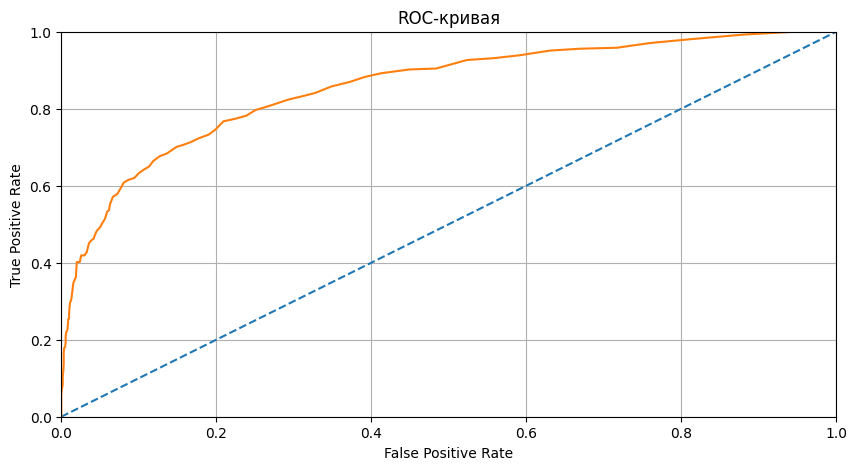

In [14]:
# Вычислим вероятность классов
proba_valid = model.predict_proba(features_valid)

# Отберем столбец, отвечающий за вероятность того, что клиент уйдёт
proba_valid_ones = proba_valid[:, 1]

# Вычислим значение AUC-ROC
auc_roc = roc_auc_score(target_valid, proba_valid_ones)
print('Значение AUC_ROC:', auc_roc)

# Построим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, proba_valid_ones)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid()
plt.show()

По графику видим, что качество модели довольно высокое. Это с учётом дисбаланса классов. Перейдём к следующему шагу.

<a id="model"></a>
### Шаг 3. Улучшение качества модели.

[в начало](#top)

Попробуем ещё повысить точность предсказания модели, убрав дисбаланс классов.

In [15]:
# Создадим функцию, которая будет увеличивать количество единиц, попутно перемешивая данные
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

# Применим созданную функцию и получим новые значения
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Проверим, что теперь классы сбалансированы.

In [16]:
print('Количество каждого значения в столбце "Exited":\n', 
      target_upsampled.value_counts(normalize=True),
     )

Количество каждого значения в столбце "Exited":
 1    0.50569
0    0.49431
Name: Exited, dtype: float64


Отлично, классы сбалансированы. Проделаем те же шаги, что и в случае с дисбалансом: обучим модель, предскажем значения на валидационной выборке и оценим значения метрик F1 и AUC-ROC с построением ROC-кривой.

F1-мера без дисбаланса классов: 0.6097240473061761
AUC-ROC без дисбаланса классов: 0.8549834035372943


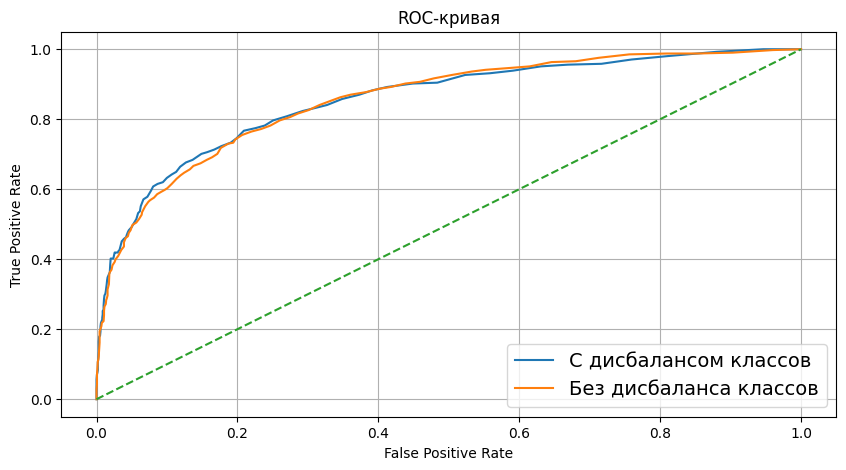

In [17]:
# Обучим новую модель и вычислим значение F1 меры
model_new = RandomForestClassifier(random_state=42)
model_new.fit(features_upsampled, target_upsampled)
print('F1-мера без дисбаланса классов:', f1_score(target_valid, model_new.predict(features_valid)))

# Вычислим значение AUC-ROC
proba_valid_new = model_new.predict_proba(features_valid)
proba_valid_new_ones = proba_valid_new[:, 1]
auc_roc_new = roc_auc_score(target_valid, proba_valid_new_ones)
print('AUC-ROC без дисбаланса классов:', auc_roc_new)

# Построим на одном графике две ROC-кривые - с дисбалансом и без него
fpr, tpr, thresholds = roc_curve(target_valid, proba_valid_ones)
plt.plot(fpr, tpr, label='С дисбалансом классов')

fpr_new, tpr_new, thresholds_new = roc_curve(target_valid, proba_valid_new_ones)
plt.plot(fpr_new, tpr_new, label='Без дисбаланса классов')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid()
plt.legend()
plt.show()

Итак, можно заметить, что значение F1 меры стало чуть выше, а значение AUC-ROC несущественно снизилось. График и вовсе показал, что с дисбалансом классов модель как будто даже лучше предсказывает.

Теперь проигнорируем дисбаланс и попробуем подобрать наилучшие параметры для нашей модели с помощью RandomizedSearchCV.

In [18]:
# Сначала объединим обучающую и валидационную выборки
features_all = pd.concat([features_train, features_valid])
target_all = pd.concat([target_train, target_valid])

# Укажем интересующие нас параметры
params = {'max_depth': range(1, 16),
          'criterion': ['gini', 'entropy'],
          'class_weight': ['balanced'],
          'n_estimators': range(1, 40, 10)
          }

# Произведем подбор лучших параметров
grid = GridSearchCV(model, params, scoring='f1', cv=5)
grid.fit(features_all, target_all)
print('Лучшая модель:', grid.best_estimator_)
print('F1 лучшей модели RandomForest:', grid.best_score_)

best_model = grid.best_estimator_

Лучшая модель: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, n_estimators=31, random_state=42)
F1 лучшей модели RandomForest: 0.6111215293067123


Значение F1 меры вышло даже лучше, чем при избавлении от дисбаланса. Значит, для финального тестирования будем использовать именно эту модель.

<a id="test"></a>
### Шаг 4. Проведение финального тестирования.

[в начало](#top)

Проверим значение F1 меры на тестовой выборке.

In [19]:
pred = best_model.predict(features_test)
f1_test = f1_score(target_test, pred)
print('F1 на тестовой выборке:', f1_test,
      '\nТочность предсказания:', accuracy_score(target_test, pred))

F1 на тестовой выборке: 0.6379310344827587 
Точность предсказания: 0.853


Прекрасно, на тестовой выборке модель показала себя ещё лучше!

Но это может быть и ловушка... Проверим модель на адекватность.

In [20]:
# Определим baseline-модель с помощью DummyClassifier.
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(features_all, target_all)
dummy_clf.predict(features_test)

# Определим качество нашей baseline-модели.
score_dummy = dummy_clf.score(features_test, target_test)
print('Качество baseline-модели:', score_dummy)

Качество baseline-модели: 0.689


Точность нашей модели намного выше точности baseline-модели, поэтому можно сделать вывод, что модель адекватна.

<a id="end"></a>
### Шаг 5. Общие выводы.

[в начало](#top)

Задача "Построить модель для задачи классификации, которая будет давать прогноз, уйдёт клиент из банка в ближайшее время или нет" выполненена. Модель имеетзначение F1 меры выше необходимого минимума: на тестовой выборке при предсказании было получено значение 0,6.

Во время выполнения проекта было произведено следующее:
- получены и оценены вводные данные;
- произведена предобработка данных для более корректного использования для составления модели;
- данные разделены на обучающую, валидационную и тестовую выборки;
- исследовано наличие дисбаланса в данных;
- произведено исследование качества модели случайного леса без подбора гиперпараметров и без учёта дисбаланса для решения поставленной задачи. При этом уже был получен необходимый результат, но пограничный. Его можно было улучшить;
- произведены манипуляции с данными, убравшие дисбаланс за счёт увеличения количества строк с наименьшим классом и перемешивания;
- исследовано качества модели без дисбаланса: модель показала лучше результат;
- в качестве альтернативной меры улучшения модели был применен метод RandomizedSearchCV, подобравший лучшие гиперпараметры для модели даже при дисбалансе классов. Как итог: модель показала результат даже лучше, чем при первом улучшении, где дисбаланс был устранён;
- проведено тестирование модели с лучшими гиперпараметрами на тестовой выборке: F1 мера имела значение 0.6. Необходимые условия задачи выполнены;
- модель проверена на адекватность с помощью сравнения её с baseline-моделью, полученную с помощью метода DummyClassifier, вывод: модель адекватна и пригодна для использования, так как показала точность выше, чем у baseline-модели.